In [ ]:
import torch


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Visualization
import networkx as nx
import matplotlib.pyplot as plt
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout, Tanh
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from torch_geometric.datasets import TUDataset
from torch.nn import Sigmoid

plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

In [ ]:

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting ./PROTEINS/PROTEINS.zip
Processing...


Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 20
Number of features: 3
Number of classes: 2


Done!


In [ ]:
dataset.get_summary()

TUDataset (#graphs=1113):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     39.1 |    145.6 |
| std        |     45.8 |    169.3 |
| min        |      4   |     10   |
| quantile25 |     15   |     56   |
| median     |     26   |     98   |
| quantile75 |     45   |    174   |
| max        |    620   |   2098   |
+------------+----------+----------+

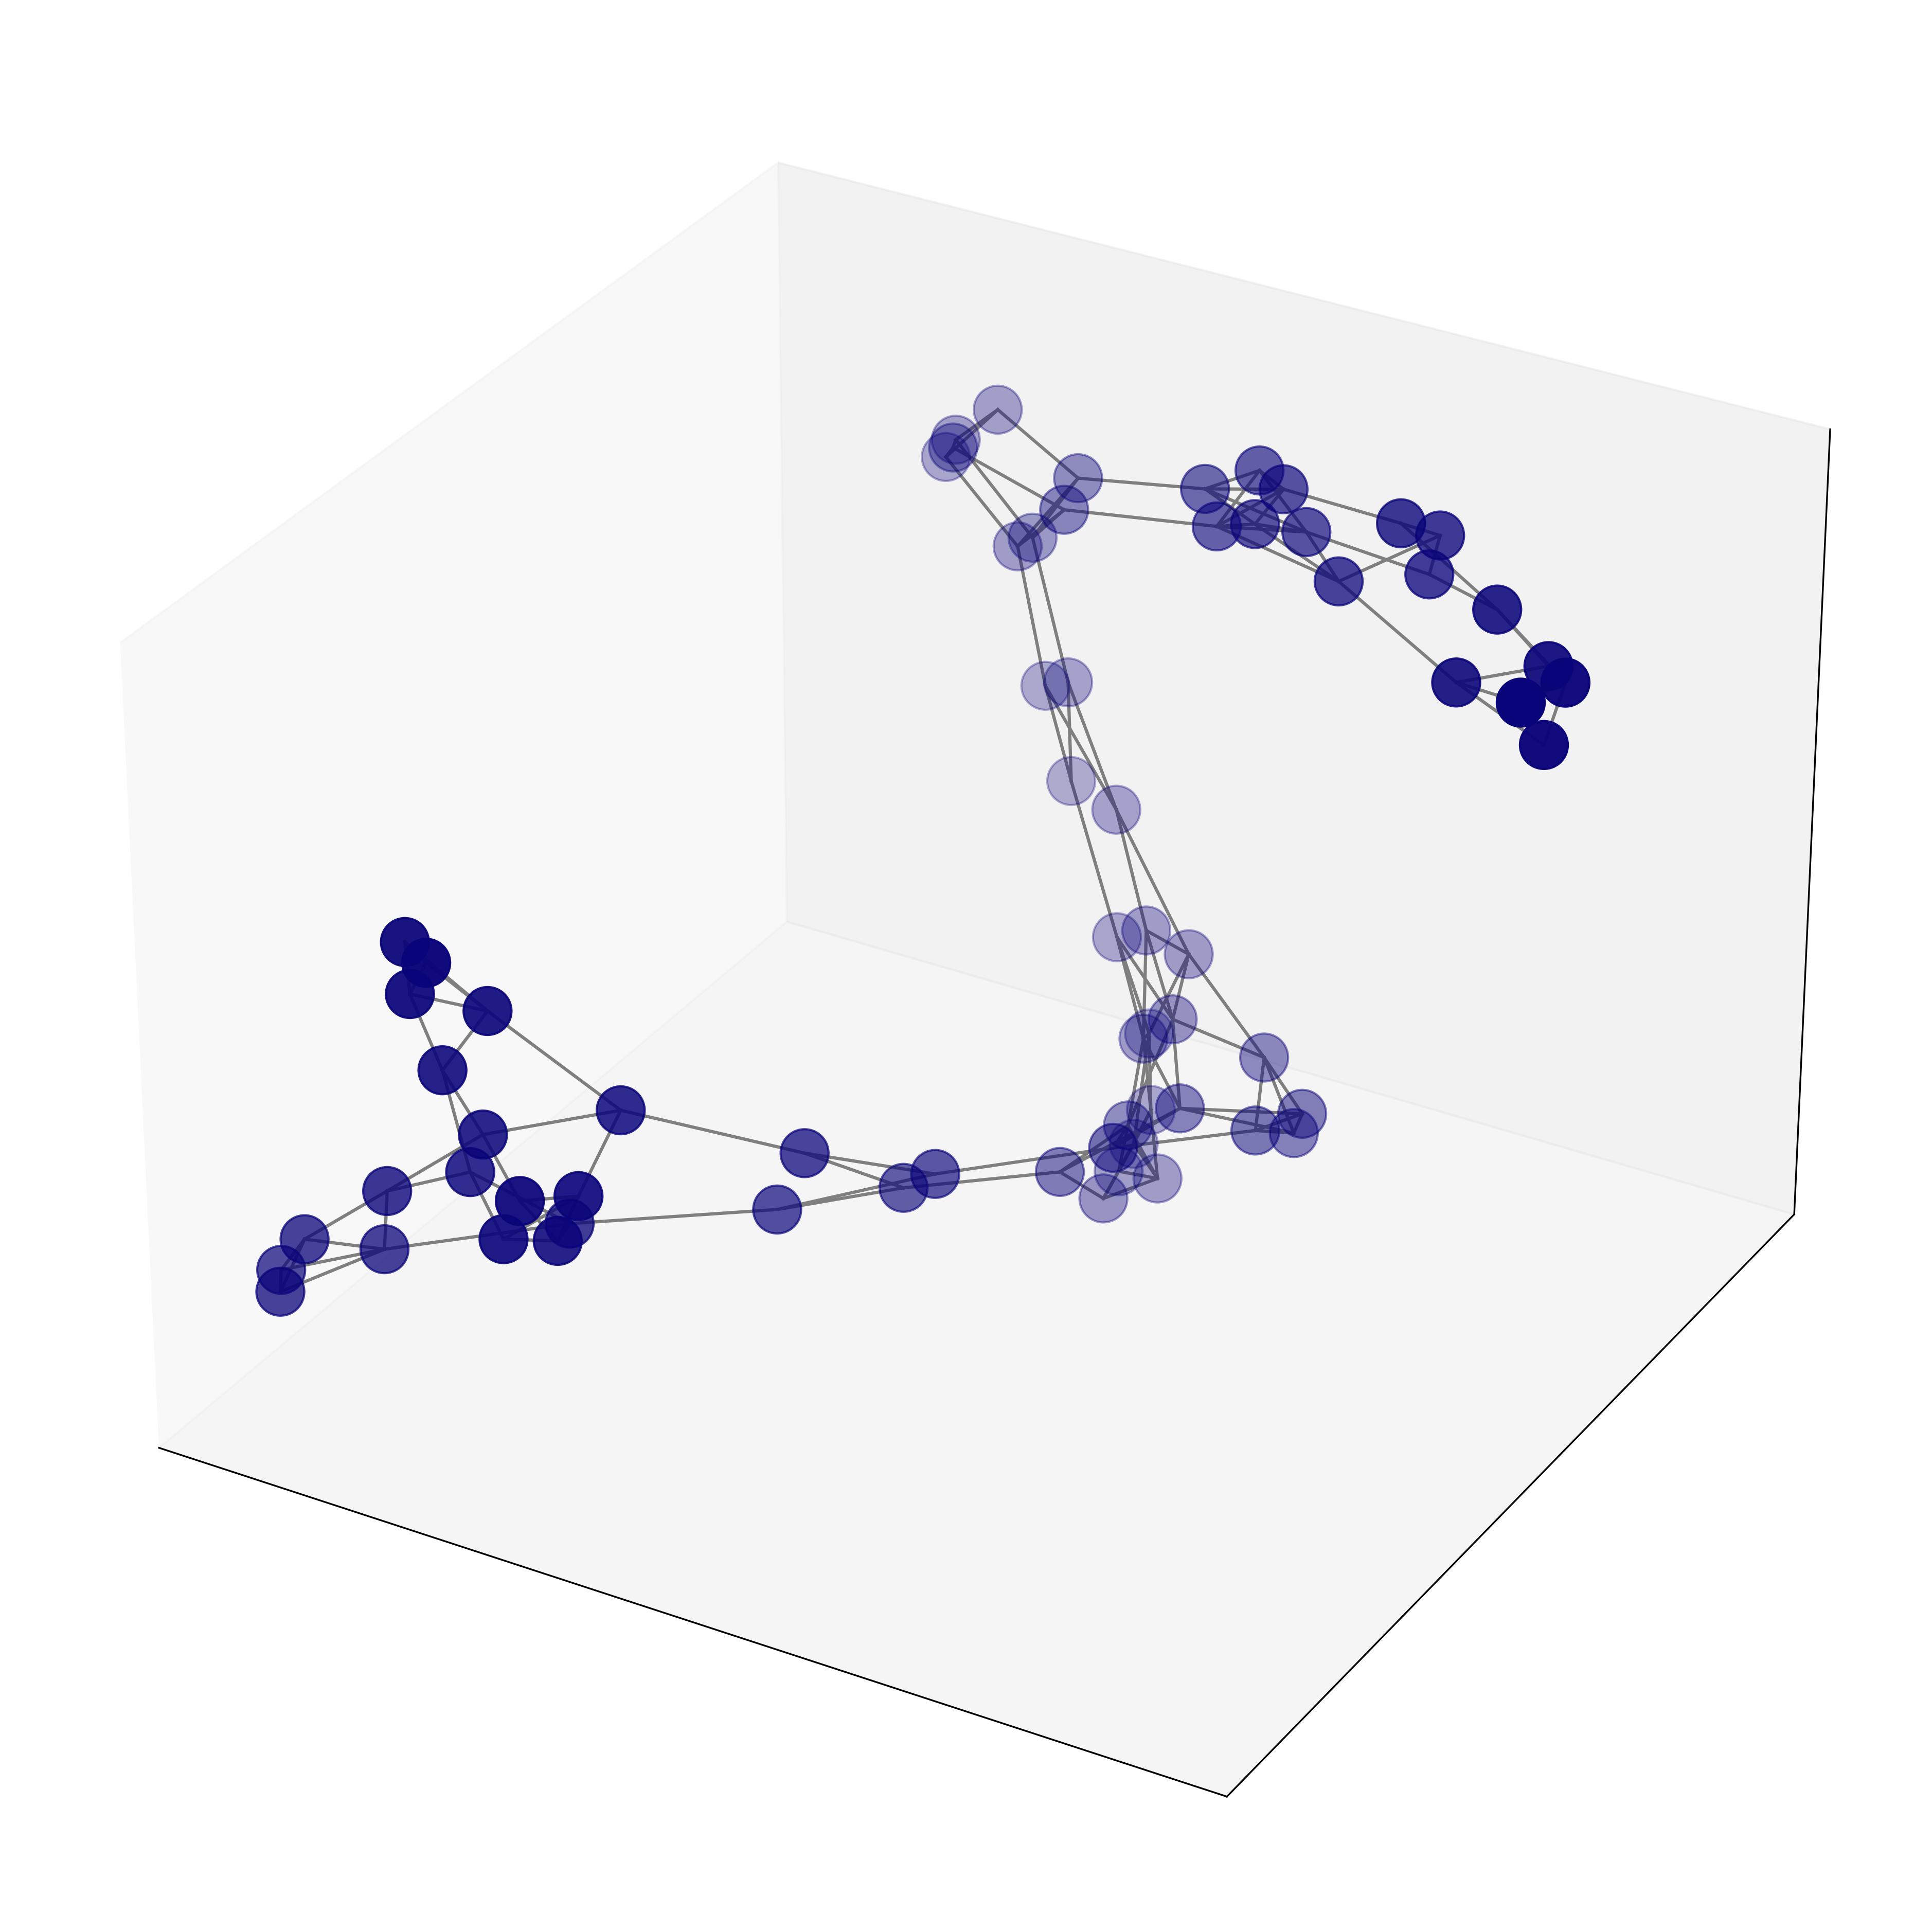

In [ ]:

G = to_networkx(dataset[1], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

In [ ]:
# We create a seed, and then shuffle our data
torch.manual_seed(12345)
dataset = dataset.shuffle()

# Once it's shuffled, we slice the data to split
train_dataset = dataset[:int(len(dataset)*0.85)]
val_dataset   = dataset[int(len(dataset)*0.85):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]


# Take a look at the training versus test graphs
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 946
Number of validation graphs: 55
Number of test graphs: 112


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, dim):
        super(GCN, self).__init__()
        # We inherit from pytorch geometric's GCN class, and we initialize three layers
        self.conv_1 = GCNConv(dataset.num_node_features, dim)
        self.conv_2 = GCNConv(dim, dim*2)
        self.conv_3 = GCNConv(dim*2, dim*3)
        self.conv_4 = GCNConv(dim*3, dim)

        # Our final linear layer will define our output
        self.lin = Linear(dim, dataset.num_classes)
        
    def forward(self, x, edge_id, batch):
      
      # 1. Obtain node embeddings 
      x = F.dropout(x, p=0.2, training=self.training)
      x = self.conv_1(x, edge_id)
      x = x.tanh()
      x = F.dropout(x, p=0.4, training=self.training)
      x = self.conv_2(x, edge_id)
      x = x.tanh()
      x = F.dropout(x, p=0.4, training=self.training)
      x = self.conv_3(x, edge_id)
      x = x.relu()
      x = F.dropout(x, p=0.2, training=self.training)
      x = self.conv_4(x, edge_id)
      # 2. Readout layer
      x1 = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

      # 3. Apply a final classifier
      x = F.dropout(x1, p=0.6, training=self.training)
      x = self.lin(x)
      return x, F.log_softmax(x, dim=1)
      

In [ ]:
# Set our optimizer (adam)
def train(model, train_loader):
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, , weight_decay=0.01)
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.05)
  # Define our loss function
  criterion = torch.nn.CrossEntropyLoss()

# Initialize our train function
  model.train()
    # Run for _ epochs (range is exclusive in the upper bound)
  for epoch in range(1, 100):

    train_acc = validate(model, train_loader)
    val_acc = validate(model, val_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%')
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
      _,out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
      loss = criterion(out, data.y)  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      optimizer.zero_grad()  # Clear gradients.

  return model
      
# Define our test function
def validate(model, loader):
  model.eval()

  correct = 0
  for data in loader:  # Iterate in batches over the training/test dataset.
      _,out = model(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred == data.y).sum())  # Check against ground-truth labels.
  return correct / len(loader.dataset)  # Derive ratio of correct predictions.





In [ ]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()
    
#@torch.no_grad()
def test(model, loader):

    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        _,out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc



In [ ]:
## tanh performs better than relu
## changing the dim from 64 to 32 did not change the results a lot
## changing from 3 to 4 layers helped
## dropout helped with overfitting

In [ ]:
gcn = GCN(dim = 32)
gcn_model = train(gcn, train_loader)
test_loss, test_acc = test(gcn_model, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 001, Train Acc: 58.46%, Val Acc: 65.45%
Epoch: 002, Train Acc: 60.89%, Val Acc: 69.09%
Epoch: 003, Train Acc: 64.06%, Val Acc: 72.73%
Epoch: 004, Train Acc: 63.85%, Val Acc: 69.09%
Epoch: 005, Train Acc: 64.80%, Val Acc: 70.91%
Epoch: 006, Train Acc: 62.47%, Val Acc: 72.73%
Epoch: 007, Train Acc: 62.79%, Val Acc: 69.09%
Epoch: 008, Train Acc: 60.99%, Val Acc: 69.09%
Epoch: 009, Train Acc: 66.38%, Val Acc: 74.55%
Epoch: 010, Train Acc: 65.86%, Val Acc: 67.27%
Epoch: 011, Train Acc: 58.46%, Val Acc: 65.45%
Epoch: 012, Train Acc: 69.56%, Val Acc: 72.73%
Epoch: 013, Train Acc: 69.24%, Val Acc: 70.91%
Epoch: 014, Train Acc: 66.49%, Val Acc: 72.73%
Epoch: 015, Train Acc: 66.60%, Val Acc: 70.91%
Epoch: 016, Train Acc: 69.77%, Val Acc: 70.91%
Epoch: 017, Train Acc: 69.03%, Val Acc: 70.91%
Epoch: 018, Train Acc: 69.03%, Val Acc: 70.91%
Epoch: 019, Train Acc: 71.04%, Val Acc: 72.73%
Epoch: 020, Train Acc: 64.48%, Val Acc: 69.09%
Epoch: 021, Train Acc: 68.39%, Val Acc: 69.09%
Epoch: 022, T

In [ ]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim),
                       BatchNorm1d(dim), Tanh(),
                       Linear(dim, dim), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), Tanh(), Dropout(0.6),
                       Linear(dim, dim), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), Tanh(), Dropout(0.6),
                       Linear(dim, dim), ReLU()))
        self.conv4 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), Tanh(), Dropout(0.6),
                       Linear(dim, dim), ReLU()))
        self.conv5 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), Tanh(), Dropout(0.6),
                       Linear(dim, dim), ReLU()))
        self.lin1 = Linear(dim*5, dim*5)
        self.lin2 = Linear(dim*5, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)
        h4 = self.conv3(h3, edge_index)
        h5 = self.conv3(h4, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)
        h4 = global_add_pool(h4, batch)
        h5 = global_add_pool(h5, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3, h4, h5), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)


In [ ]:
gin = GIN( dim = 32)
print(gin)
gin_model = train(gin, train_loader)
test_loss, test_acc = test(gin_model, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
  ))
  (conv4): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features

In [ ]:
print(gcn)

GCN(
  (conv_1): GCNConv(3, 32)
  (conv_2): GCNConv(32, 64)
  (conv_3): GCNConv(64, 96)
  (conv_4): GCNConv(96, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc = 0

for data in test_loader:
    # Get classifications
    _, out_gcn = gcn(data.x, data.edge_index, data.batch)
    _, out_gin = gin(data.x, data.edge_index, data.batch)
    out = (out_gcn + out_gin)/2 #take average of the output tensor

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN + GIN accuracy: {acc*100:.2f}%')

GCN accuracy:     75.26%
GIN accuracy:     80.47%
GCN + GIN accuracy: 79.43%


In [ ]:
out_gin.argmax(dim=1)

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

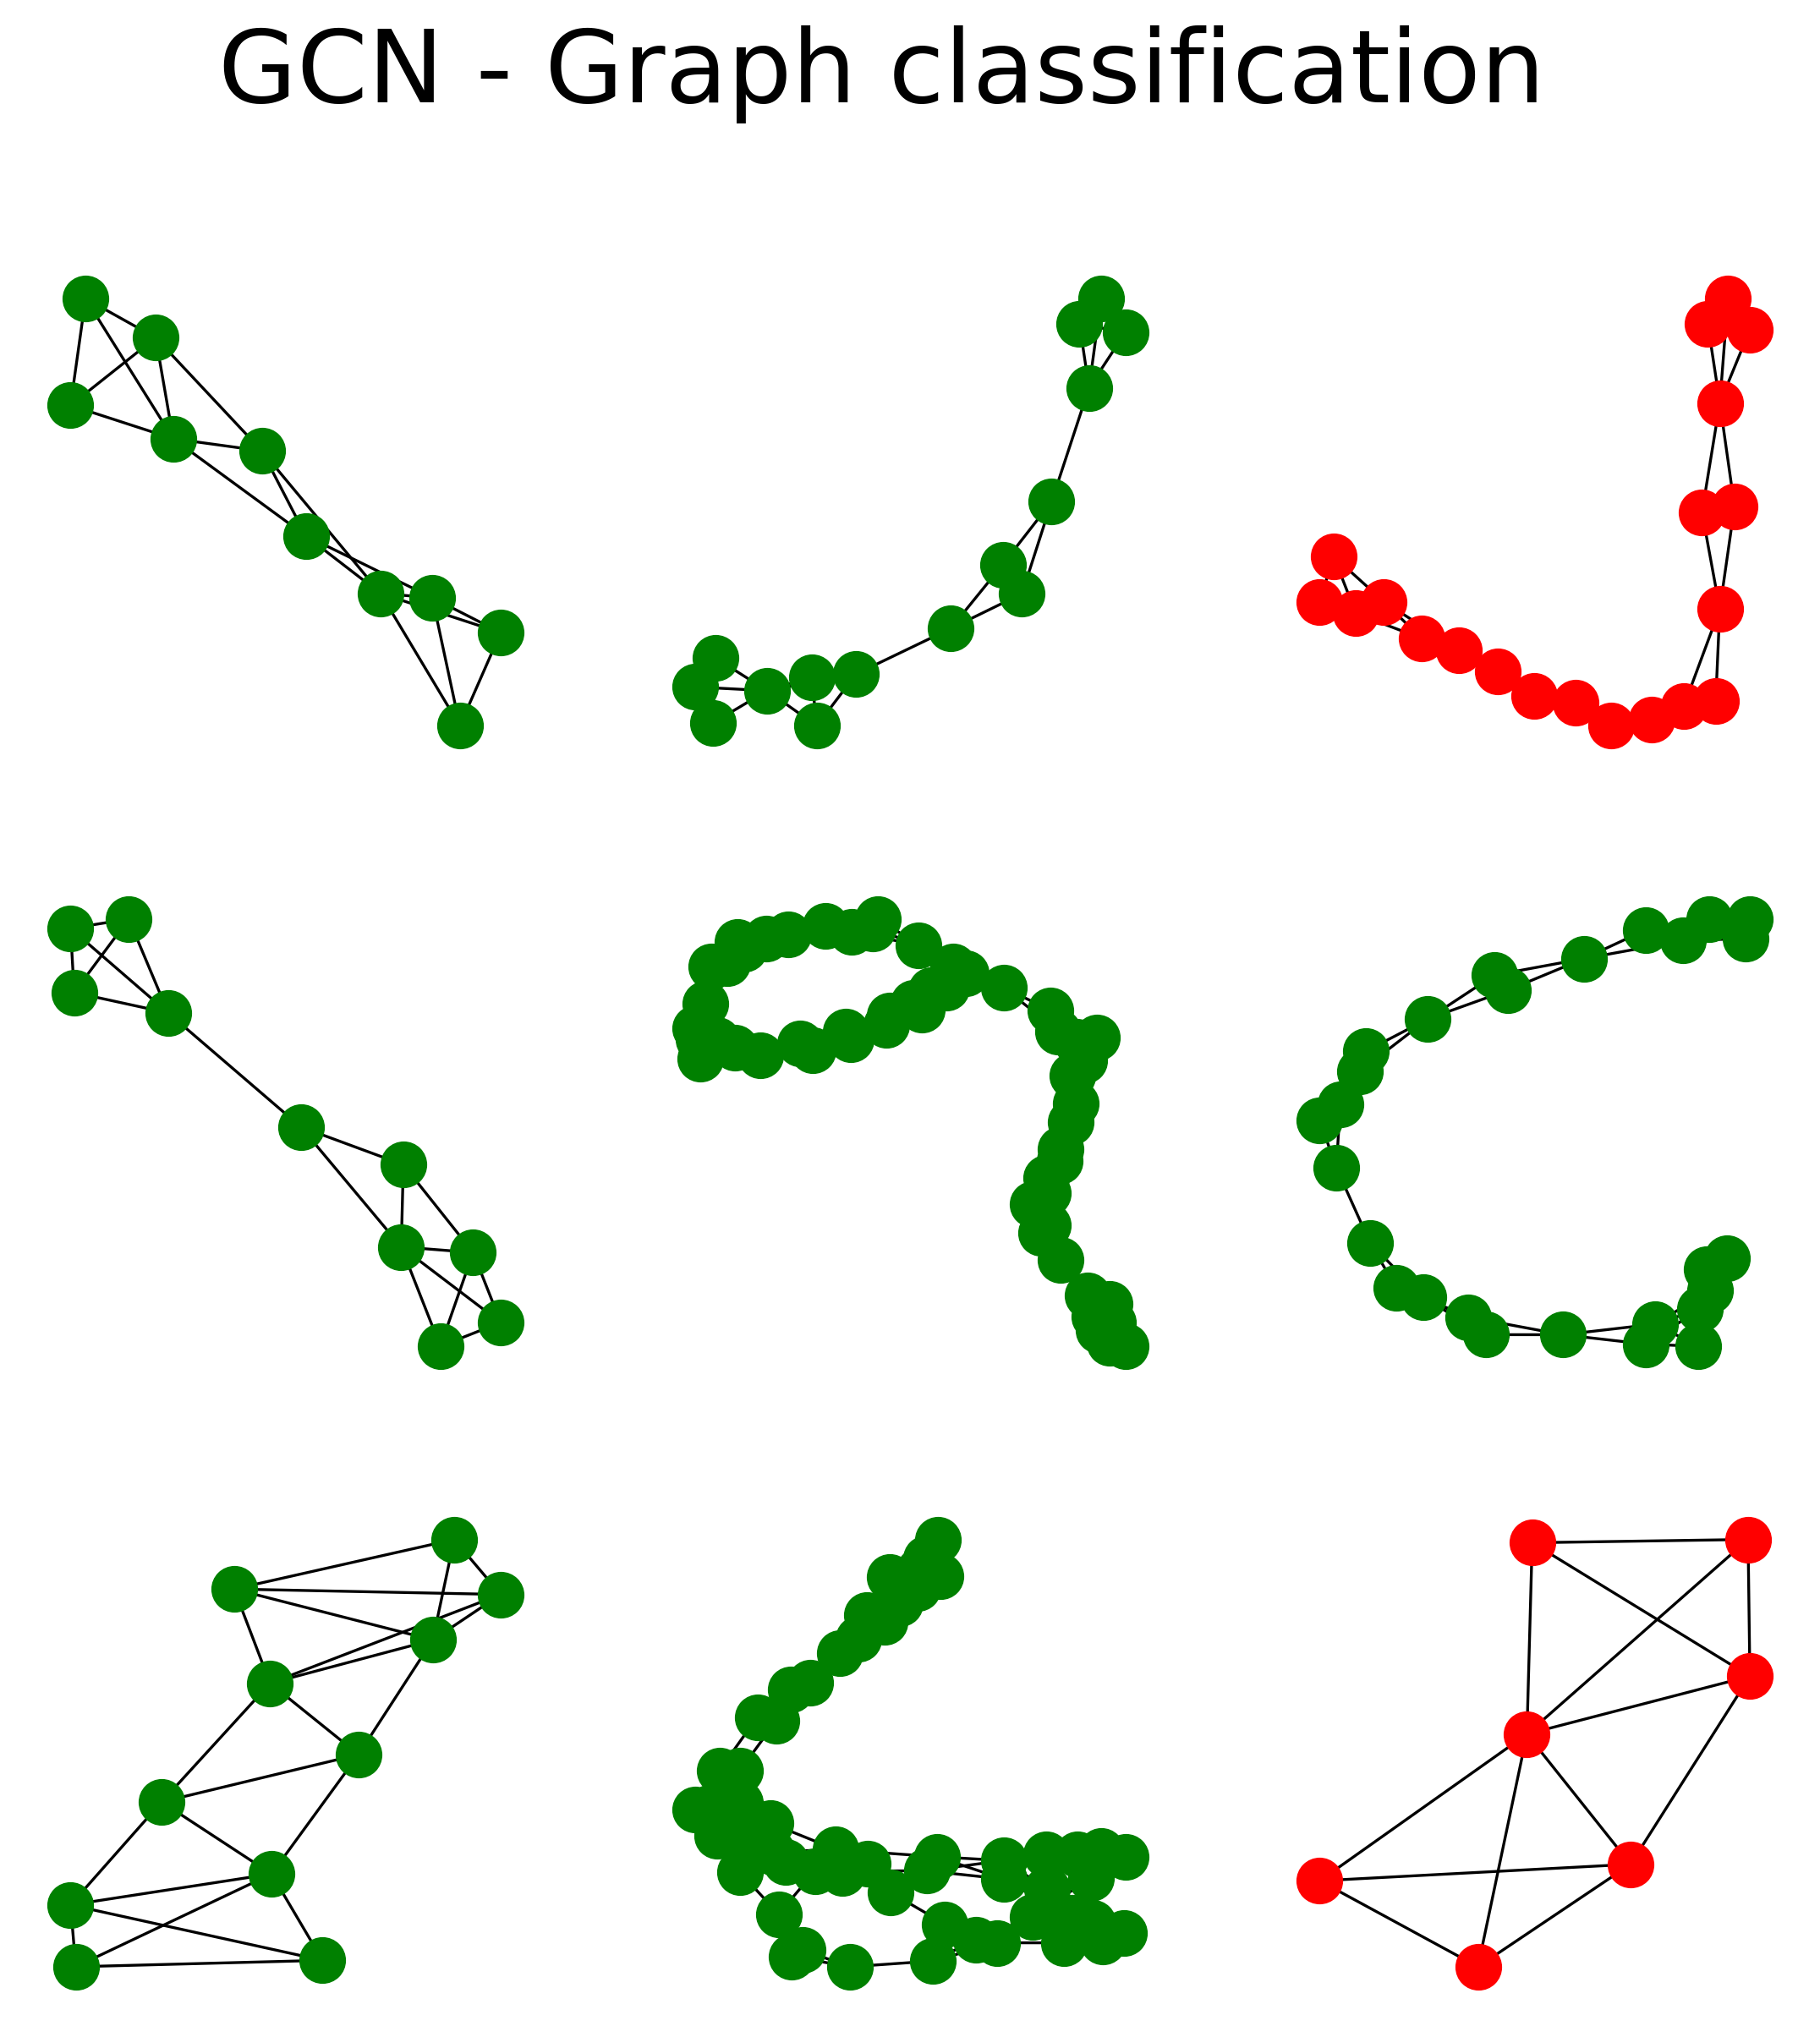

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(9,9))
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[1080:1089]):
    # Calculate color (green if correct, red otherwise)
    _, out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

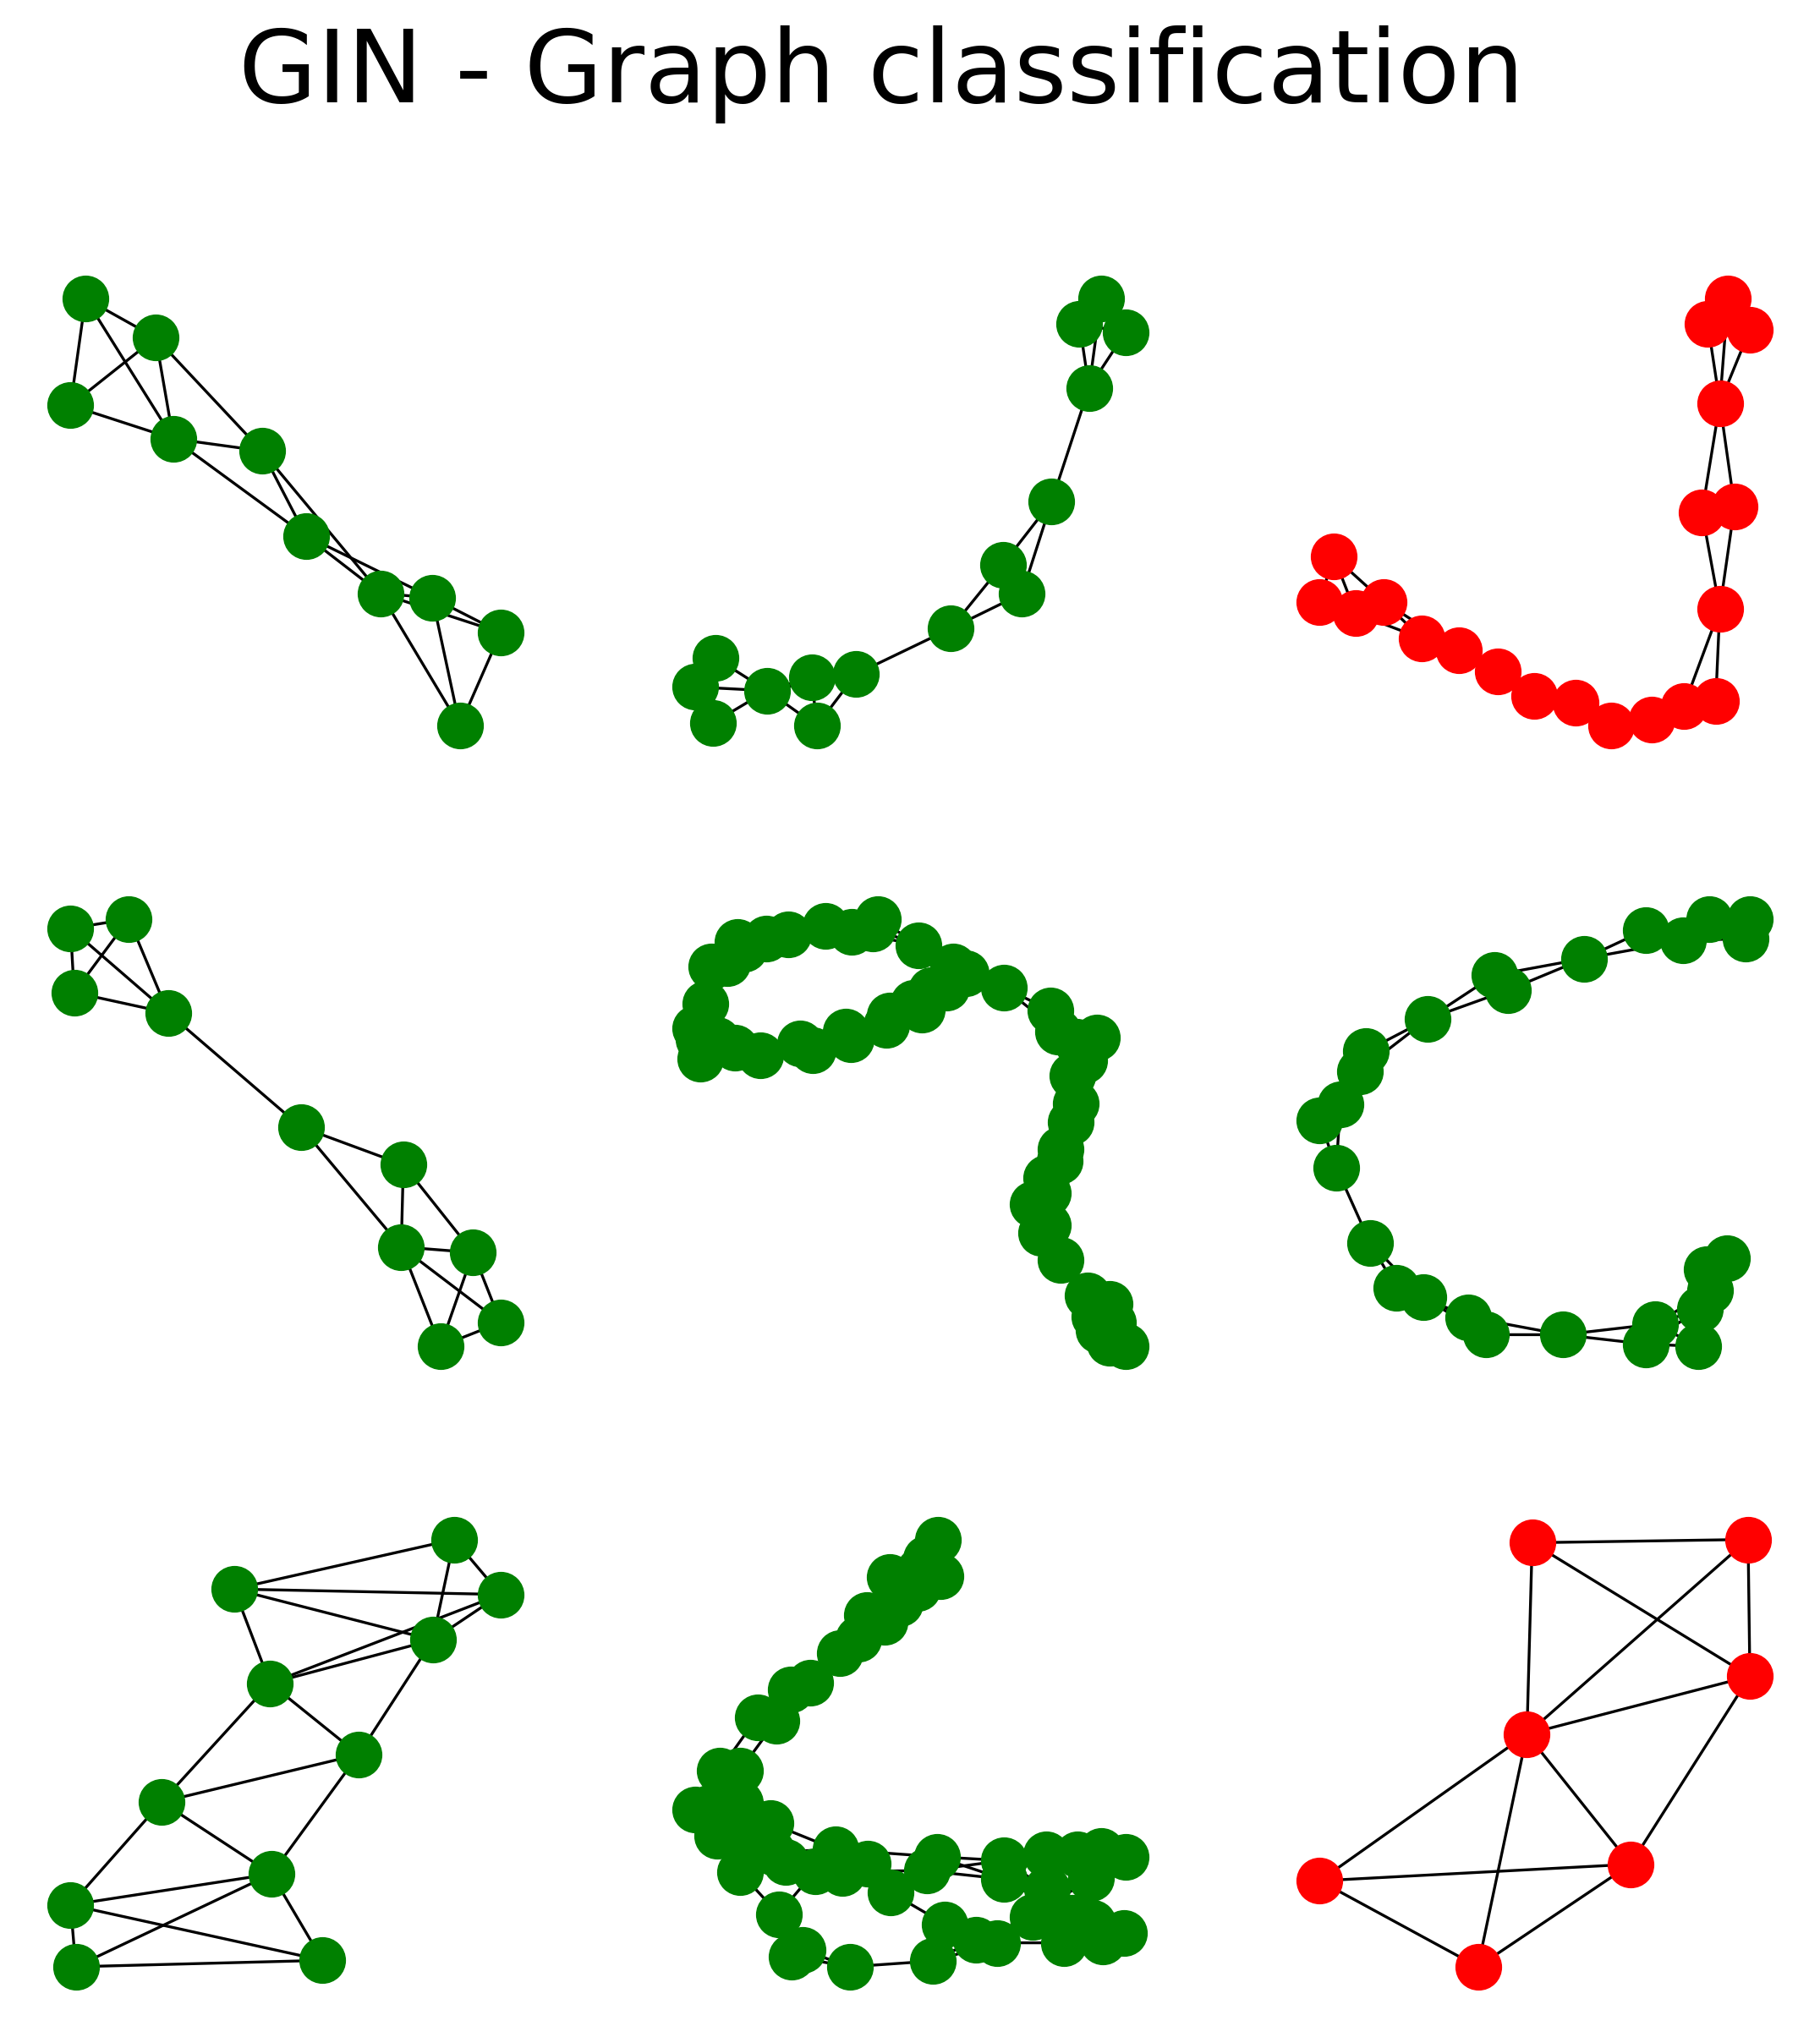

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(9,9))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[1080:1089]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )